<a href="https://colab.research.google.com/github/Khaganshu-RK/Conversational-Chatbot/blob/Pose_action_detection/pose_action_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pose Detection for Action Recognition

### Importing packages

In [ ]:
# Import the basic and important packages
import os
import random
import glob
import h5py
from __future__ import print_function

# Import numpy for matrix operations and pandas for data handling
import numpy as np
import pandas as pd

#OpenCV package for processing images
import cv2 as cv

# Matplotlib for plotting images and graphs
import matplotlib.pyplot as plt
%matplotlib inline

# Sklearn is a Machine Learning package in python. Helps in splitting the dataset
from sklearn.model_selection import train_test_split

# Keras package for working with the deep learning model
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras import backend as K
from keras import applications
K.clear_session()

### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Unzip the Preprocessed Datasets

In [ ]:
!unzip -qq "/content/drive/MyDrive/Projectfiles/Pose&action_Detection/Pose_Dataset.zip"
!unzip -qq "/content/drive/MyDrive/Projectfiles/Pose&action_Detection/Action_Dataset.zip"
!unzip -qq "/content/drive/MyDrive/Projectfiles/Pose&action_Detection/Pose_Model.zip"

### Datasets Used
* Action_Dataset : Preprocessed FLIC Dataset (Frames Labeled In Cinema) from http://bensapp.github.io/flic-dataset.html
* Pose_Dataset : Custom dataset with actions 'Namaste' and 'Hello'

### Load the training dataset

In [ ]:
# Load the train data
train = pd.read_csv('Pose_Dataset/train_joints_coords.csv', header = None)

# Split dataset into training and validation sets
# test_size defines the split ratio of testing size. Here it is validation set.
train_img_ids, val_img_ids, train_jts, val_jts = train_test_split(train.iloc[:,0], train.iloc[:,1:], test_size=0.2, random_state=42)

# Load validation images
train_images = np.array([cv.imread('Pose_Dataset/train/{}'.format(x)) for x in train_img_ids.values])
val_images = np.array([cv.imread('Pose_Dataset/train/{}'.format(x)) for x in val_img_ids.values])

# Convert the pandas dataframe to numpy array
train_images,train_jts = np.array(train_images),np.array(train_jts)
val_images,val_jts = np.array(val_images),np.array(val_jts)

# Convert validation images to dtype float
train_images = train_images.astype(float)
val_images = val_images.astype(float)

# Samples in the dataset
print('Number of training set images:',train_images.shape[0])
print('Number of validation set images:',val_images.shape[0])
# Dataset features and target shape
print('Training set shape:',train_images.shape,'\nTraining set target shape:',train_jts.shape)
print('Validation set shape:',val_images.shape,'\nValidation set target shape:',val_jts.shape)

Number of training set images: 3543
Number of validation set images: 886
Training set shape: (3543, 224, 224, 3) 
Training set target shape: (3543, 14)
Validation set shape: (886, 224, 224, 3) 
Validation set target shape: (886, 14)


### Load the testing dataset

In [ ]:
test = pd.read_csv('Pose_Dataset/test_joints_coords.csv', header = None)
test_img_ids, test_jts = test.iloc[:,0], test.iloc[:,1:]
test_images = np.array([cv.imread('Pose_Dataset/test/{}'.format(x)) for x in test_img_ids.values])
test_images = test_images.astype(float)
test_images,test_jts = np.array(test_images),np.array(test_jts)
print('Number of testing set images:',test_images.shape[0])
print('Testing set shape:',test_images.shape,'\nTesting set target shape:',test_jts.shape)

Number of testing set images: 574
Testing set shape: (574, 224, 224, 3) 
Testing set target shape: (574, 14)


### Plotting the joints of the body

In [ ]:
# Function to draw the joints
def plot_joints(img, joints, groundtruth=True, invert=False):
    if not invert:
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    h, w, c = img.shape
    # Plot the limbs
    color = (255,255,255)
    img = cv.line(img, joints[0], joints[1], color, thickness=2, lineType=16)# left hand to left elbow
    img = cv.line(img, joints[1], joints[2], color, thickness=2, lineType=16)# left elbow to left shoulder
    img = cv.line(img, joints[2], joints[4], color, thickness=2, lineType=16)# left shoulder to right shoulder
    img = cv.line(img, joints[4], joints[5], color, thickness=2, lineType=16)# right shoulder to right elbow
    img = cv.line(img, joints[5], joints[6], color, thickness=2, lineType=16)# right elbow to right hand

    # Compute and plot the neck coordinate
    joints.append(tuple((np.array(joints[2]) + np.array(joints[4])) // 2))
    img = cv.line(img, joints[3], joints[7], color,thickness=2, lineType=16)
    joints.pop()

    if groundtruth:
        color = (50,155,70) # Choose green color for ground truth
    else:
        color = (50,70,155) # Choose blue color for our detection

    # Plot the joints
    for j, joint in enumerate(joints):
        cv.circle(img, joint, 5, color, -1)
        cv.putText(img, '%d'%j, joint, cv.FONT_HERSHEY_SIMPLEX, 0.5,
                   (255, 255, 255), thickness=1, lineType=16)
    return img

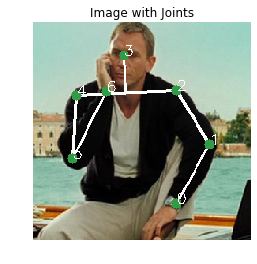

In [ ]:
ind = 50 # Any image index can be given here
image = train_images[ind,:,:,:]
image = np.array(image,np.int32)
joints = train_jts[ind,:]
joints = list(zip(joints[0::2], joints[1::2]))

plotted_image=plot_joints(image, joints, groundtruth=True, invert=True)
plt.title('Image with Joints')
plt.axis('off')
plt.imshow(plotted_image)

### Setting seed value

In [ ]:
# You can set the seed value for reproducibility of the model
seed_value = 9000 # Any integer number can be given as a seed
np.random.seed(seed_value)
random.seed(seed_value)
# The above seed has to be reset everytime if you want same random numbers

### Experimental Setup

In [ ]:
K.clear_session()

no_epochs = 5 # Number of epochs
batch_size = 128 # Batchsize i.e. number of samples processed for updating the weights
ip_img_shape = (224, 224, 3) # Shape of the input image

### Building a Model Architecture

In [ ]:
pose_model = Sequential() # Initializing the model

pose_model.add(Conv2D(64, kernel_size=(7,7), strides=3, activation='relu', input_shape=ip_img_shape))
pose_model.add(MaxPooling2D(pool_size=(3,3)))
pose_model.add(Conv2D(64, kernel_size=(7,7), strides=2, activation='relu'))
pose_model.add(MaxPooling2D(pool_size=(3,3)))
pose_model.add(Flatten()) # Ouput of previous layer is flattened into vector
pose_model.add(Dropout(0.25))
pose_model.add(Dense(256, activation='relu')) # Fully connected layer
pose_model.add(Dropout(0.5))
pose_model.add(Dense(14, activation='relu')) # Final layer for joints coordinates regression

pose_model.summary() # Print the model summary

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 64)        9472      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          200768    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dropout_1 (Dropout)  

### Note
* __Activation Functions__: We can use other activation functions such as sigmoid, tanh, softmax(for last layer of classification), elu, selu, softplus. For more info: https://keras.io/activations/
* __Conv2D__: We are not using padding since the boarder of the input image does not contain useful pixel for predicting the joints. Padding can be used as parameter padding='same'
* __Dropout__: Used for reducing overfitting of the model to the training data. Applied especially to layer with large number of nodes
* __Pooling__: Used to downsize the output of convolution
* __Layers__: Model can have any number of Conv2D layers. Purpose of Convolution is to reduce the dimension of the tensor volume so that fully-connected (FC) layers will not be larger dimensional.
* __Filters__: The number of filters in the CNN model will gradually increase since the possibilities of first layer convolutions features are smaller than than the convolutional layers in the deeper level


### Compiling the model

In [ ]:
optimizer = Adam(lr=0.01, beta_1=0.5) # Defining the optimizer
pose_model.compile(loss="mean_squared_error", optimizer=optimizer) # Compile the model
# mean_squared_error is used as the model output is prediction/regression of joint coordinates

### Filter weights before training

Shape of 1st layer filter weights:  (7, 7, 3, 64)
Visualization of 1st layer filter weights


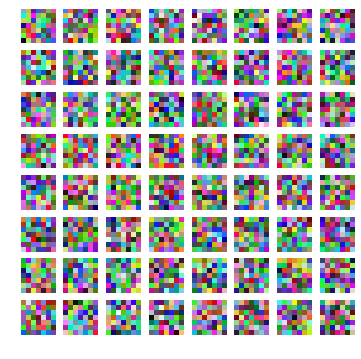

In [ ]:
# Extracting weights and biases of the model
w = []
for layer in pose_model.layers:
    weights = layer.get_weights()
    w.append(weights)

layer1 = np.array(w[0][0]) # 1st layer weights
print("Shape of 1st layer filter weights: ",layer1.shape)
print("Visualization of 1st layer filter weights")
fig=plt.figure(figsize=(6, 6))
columns = 8 # Number of filters in the first layer should be divisible by 8
rows = int(layer1.shape[3]/8)
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    # Normalize the weights to 0 to 1 using min-max normalization ((x-min(x))/(max(x)-min(x))
    layer1[:,:,:,i-1] = (layer1[:,:,:,i-1]-np.amin(layer1[:,:,:,i-1]))/(np.amax(layer1[:,:,:,i-1])-np.amin(layer1[:,:,:,i-1]))
    # Scale it to 0 to 255
    layer1[:,:,:,i-1]*=255
    plt.axis('off')
    plt.imshow(layer1[:,:,:,i-1].astype(np.uint8))
plt.show()

# The below is the visualization of the random weights of the first layer filters
# These weights will change after training
# Note: Only the 1st layer filter weights can be visualized as RGB images since filters have 3 channels

### Training the model

In [ ]:
history = pose_model.fit(train_images, train_jts, batch_size=batch_size,
                         epochs=no_epochs, verbose=1, validation_data=(val_images, val_jts))
# History variable will store the loss/accuracy during training
# Model weights and biases will be updated during the training
# Monitor the validation loss for each epoch

Instructions for updating:
Use tf.cast instead.
Train on 3543 samples, validate on 886 samples
Epoch 1/5
3543/3543 [==============================] - 8s 2ms/step - loss: 46431030.4679 - val_loss: 10199.9178
Epoch 2/5
3543/3543 [==============================] - 4s 1ms/step - loss: 7011.5716 - val_loss: 1475.7699
Epoch 3/5
3543/3543 [==============================] - 4s 1ms/step - loss: 2012.7215 - val_loss: 752.8927
Epoch 4/5
3543/3543 [==============================] - 4s 1ms/step - loss: 1851.1062 - val_loss: 715.7721
Epoch 5/5
3543/3543 [==============================] - 4s 1ms/step - loss: 1814.3559 - val_loss: 717.6537


### Plot the loss during Training

dict_keys(['val_loss', 'loss'])


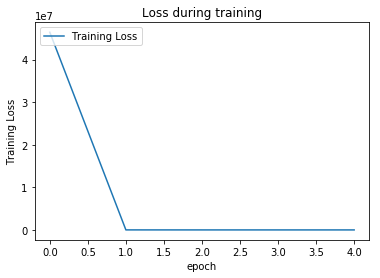

In [ ]:
# List all keys in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('Loss during training')
plt.ylabel('Training Loss')
plt.xlabel('epoch')
plt.legend(['Training Loss'], loc='upper left')
plt.show()

### Testing the model

In [ ]:
score = pose_model.evaluate(test_images, test_jts, verbose=0)
# Trained model will be evaluated during the testing

print('Test loss:', score)
# In case of classification, accuracy will also be returned by evaluate() function

Test loss: 1047.4650455700812


### Inference

In [ ]:
img_ind = 1 # We can give any image index within the range of testing set images
prediction = pose_model.predict(np.expand_dims(test_images[img_ind,:,:,:], axis=0))
print('Prediction shape:',prediction.shape)

Prediction shape: (1, 14)


### Saving the pose estimation model

In [ ]:
# Structure of the model will be save in the json file
model_json = pose_model.to_json()
with open("pose_model.json", "w") as json_file:
    json_file.write(model_json)

# Weights and biases of the model will be save in the h5 file
pose_model.save_weights("pose_model.h5")
print("Saved model to disk")

Saved model to disk


### Filter weights after training

Shape of 1st layer filter weights:  (7, 7, 3, 64)
Visualization of 1st layer filter weights


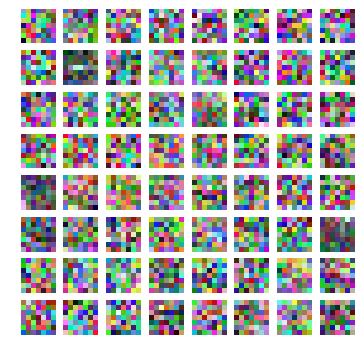

In [ ]:
# Extracting weights and biases of the model
w = []
for layer in pose_model.layers:
    weights = layer.get_weights()
    w.append(weights)

layer1 = np.array(w[0][0]) # 1st layer weights
print("Shape of 1st layer filter weights: ",layer1.shape)
print("Visualization of 1st layer filter weights")
fig=plt.figure(figsize=(6, 6))
columns = 8 # Number of filters in the first layer should be divisible by 8
rows = int(layer1.shape[3]/8)
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    # Normalize the weights to 0 to 1 using min-max normalization ((x-min(x))/(max(x)-min(x))
    layer1[:,:,:,i-1] = (layer1[:,:,:,i-1]-np.amin(layer1[:,:,:,i-1]))/(np.amax(layer1[:,:,:,i-1])-np.amin(layer1[:,:,:,i-1]))
    # Scale it to 0 to 255
    layer1[:,:,:,i-1]*=255
    plt.axis('off')
    plt.imshow(layer1[:,:,:,i-1].astype(np.uint8))
plt.show()

# The below is the visualization of the trained weights of the first layer filters
# Change might be only minimal however after training a lot edge like patterns will appear

### Loading the pose estimation model

In [ ]:
from keras.models import model_from_json

# Load json and create model
json_file = open('pose_model_50.json', 'r')
pose_model = json_file.read()
json_file.close()
pose_model = model_from_json(pose_model)

# Load weights and biases
pose_model.load_weights("pose_model_50.h5")
print("Loaded model from disk")

# Compile the model in case of retraining/fine-tuning
pose_model.compile(optimizer=Adam(lr=0.0001, beta_1=0.5),
                     loss='mean_squared_error')
# You can retrain/fine-tune the model or do inference with the model

Loaded model from disk


### Plotting a prediction

Prediction Shape: (1, 14)


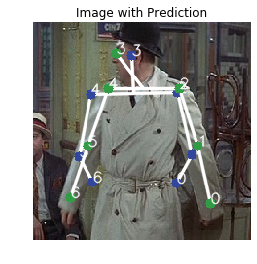

In [ ]:
img_ind = 400 # We can give any image index within the range of testing set images
# Inference with the model
prediction = pose_model.predict(np.expand_dims(test_images[img_ind,:,:,:], axis=0))
print('Prediction Shape:',prediction.shape)

#Plot the prediction: Blue joints
prediction = prediction[0].astype(np.uint8).tolist()
prediction = list(zip(prediction[0::2], prediction[1::2]))
plotted_image=plot_joints(test_images[img_ind,:,:,:].astype(np.uint8),
                          prediction, groundtruth=False, invert=True)

#Plot the groundtruth: Green joints
ground_truth = test_jts[img_ind,:]
ground_truth = ground_truth.astype(np.uint8).tolist()
ground_truth = list(zip(ground_truth[0::2], ground_truth[1::2]))
plotted_image=plot_joints(plotted_image, ground_truth, groundtruth=True, invert=True)
plt.title('Image with Prediction')
plt.axis('off')
plt.imshow(plotted_image)

### Lets do prediction with new image
The pose estimation model expects human image as input which can be output of any human/pedestrian detector. Model might not work properly is the human inside the image small in scale and placed in arbitrary location.
New image has to be resized to size 224*224.

In [ ]:
!wget -q https://jansattawpcontent.s3.amazonaws.com/uploads/2014/10/modi-namaste.jpg -O test.jpg

Original Image Shape:  (400, 620, 3)
Cropped Image Shape:  (224, 224, 3)


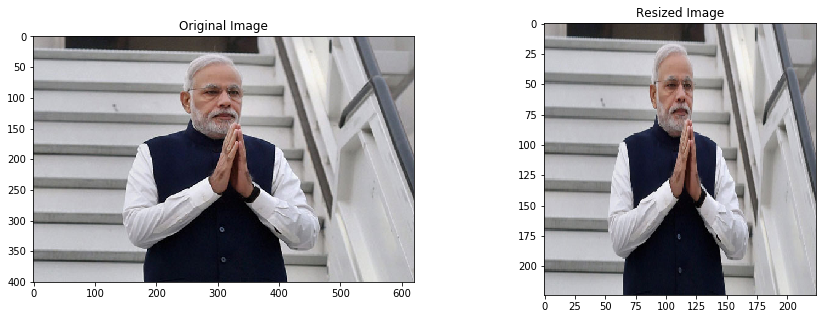

In [ ]:
original_image = cv.imread('test.jpg', cv.IMREAD_COLOR)

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(cv.cvtColor(original_image, cv.COLOR_BGR2RGB))

# plot the cropped image
plt.subplot(1,2,2)
plt.title('Resized Image')
resized_image = cv.resize(original_image, (224, 224))
plt.imshow(cv.cvtColor(resized_image, cv.COLOR_BGR2RGB))
print("Original Image Shape: ",original_image.shape)
print("Cropped Image Shape: ",resized_image.shape)

Prediction Shape: (1, 14)
Coordinates of the joints:  [(148, 166), (164, 137), (149, 73), (102, 34), (59, 75), (47, 139), (61, 165)]


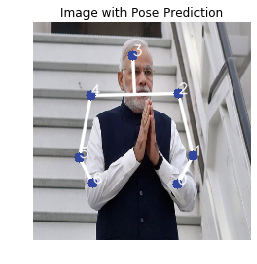

In [ ]:
image = cv.resize(original_image, (224, 224))
prediction = pose_model.predict(np.expand_dims(image, axis=0)) # Inference with the model
print('Prediction Shape:',prediction.shape)

#Plot the prediction
prediction = prediction[0].astype(np.uint8).tolist()
prediction = list(zip(prediction[0::2], prediction[1::2]))
print('Coordinates of the joints: ',prediction)
plotted_image=plot_joints(image.astype(np.uint8), prediction, groundtruth=False)

plt.title('Image with Pose Prediction')
plt.axis('off')
plt.imshow(plotted_image)

### Analysis of Pose Estimation
The model we have developed so far has found some way to reduce the overall error of the dataset by predicting obvious and highly occurring pose joints. __Solution__: Large scale data with variety + Better model architecture + More training + Parameter tuning.

## Transfer Learning (Optional)

In [ ]:
# This single line will download the pretrained model architecture trained on Imagenet dataset
mobilenet_model = applications.mobilenet.MobileNet(input_shape=(224, 224, 3), alpha=1.0, depth_multiplier=1, dropout=1e-3, include_top=False, weights='imagenet', input_tensor=None, pooling=None, classes=1000)
mobilenet_model.summary()

17227776/17225924 [==============================] - 0s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_b

### Freeze the weights of the base pretrainined model

In [ ]:
# Set layers as non-trainable
for layer in mobilenet_model.layers:
    layer.trainable = False
# The number of non-trainable parameters can be observed in the model summary

### Add new layers to the model

In [ ]:
# Adding new custom layers
x = mobilenet_model.output
x = Flatten()(x) # Flattening the output of based model in case it is convolutional tensorf volume
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(14, activation="relu")(x)
# Dense layer with 14 neurons for predicting joints

### Construct the transfer learning model

In [ ]:
pose_transfer_model = Model(inputs = mobilenet_model.input, outputs = predictions)# creating the final model
pose_transfer_model.compile(loss = "mean_squared_error", optimizer = optimizer)# compile the model
pose_transfer_model.summary()# print summary

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

### Training the transfer learning model

In [ ]:
train_history = pose_transfer_model.fit(train_images, train_jts, batch_size=batch_size, epochs=1, verbose=1)

Epoch 1/1
3543/3543 [==============================] - 9s 3ms/step - loss: 3179741.1586


### Testing the transfer learning model

In [ ]:
score = pose_transfer_model.evaluate(test_images, test_jts, verbose=0)
print('Test loss:', score)

Test loss: 15071.78204622169


### Saving the transfer learning pose estimation model

In [ ]:
# Structure of the model will be save in the json file
model_json = pose_transfer_model.to_json()
with open("pose_transfer_model.json", "w") as json_file:
    json_file.write(model_json)

# Weights and biases of the model will be save in the h5 file
pose_transfer_model.save_weights("pose_transfer_model.h5")
print("Saved model to disk")

Saved model to disk


### Other pretrained models for transfer learning
* __Xception__<br>
keras.applications.xception.Xception(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)<br>
* __VGG16__<br>
keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)<br>
* __VGG19__<br>
keras.applications.vgg19.VGG19(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)<br>
* __ResNet__<br>
keras.applications.resnet.ResNet50/ResNet101/ResNet152(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)<br>
keras.applications.resnet_v2.ResNet50V2/ResNet101V2/ResNet152V2(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)<br>
keras.applications.resnext.ResNeXt50/ResNeXt101(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)<br>
* __InceptionV3__<br>
keras.applications.inception_v3.InceptionV3(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)<br>
* __InceptionResNetV2__<br>
keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)<br>
* __DenseNet__<br>
keras.applications.densenet.DenseNet121/DenseNet169/DenseNet201(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)<br>
* __NASNet__<br>
keras.applications.nasnet.NASNetLarge(input_shape=None, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000)<br>
keras.applications.nasnet.NASNetMobile(input_shape=None, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000)<br>
* __MobileNetV2__<br>
keras.applications.mobilenet_v2.MobileNetV2(input_shape=None, alpha=1.0, depth_multiplier=1, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000)<br>

More information can be found at https://keras.io/applications/

# Action Recognition using Pose Landmarks

### Load dataset with pose joints

In [ ]:
# Dataset contain 20 training images and 2 images for inference and error analysis
# Input features: 14 float numbers representing 7 body joints xy coordinates
# Target: 2 classes such as 'Namaste' and 'Hello'
dataset = pd.read_csv('Action_Dataset/action_joints.csv')
print(dataset)

                 url  j1x  j1y  j2x  j2y  j3x  ...  j5y  j6x  j6y  j7x  j7y    label
0         hello1.jpg  152  205  165  152  157  ...   90   81   74   48   28    Hello
1         hello2.jpg  142  184  144  133  134  ...   84   60   65   45   19    Hello
2         hello3.jpg  155  202  151  149  141  ...  105   47   73   53   40    Hello
3         hello4.jpg  167  216  159  161  165  ...   88   41  102   65   49    Hello
4         hello5.jpg  140  194  137  144  131  ...   92   60   75   60   37    Hello
5         hello6.jpg  189  218  174  169  157  ...  117   67   94   43   46    Hello
6         hello7.jpg  184  188  168  137  153  ...   92   69   70   76   25    Hello
7         hello8.jpg  179  161  171  118  162  ...   64   85   49   48   27    Hello
8         hello9.jpg  154  180  160  152  143  ...   97   55   79   82   36    Hello
9        hello10.jpg  174  193  172  140  158  ...   95   72   70   61   30    Hello
10      namaste1.jpg  119   98  164  142  150  ...   75   65  146

### Plot the dataset images

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


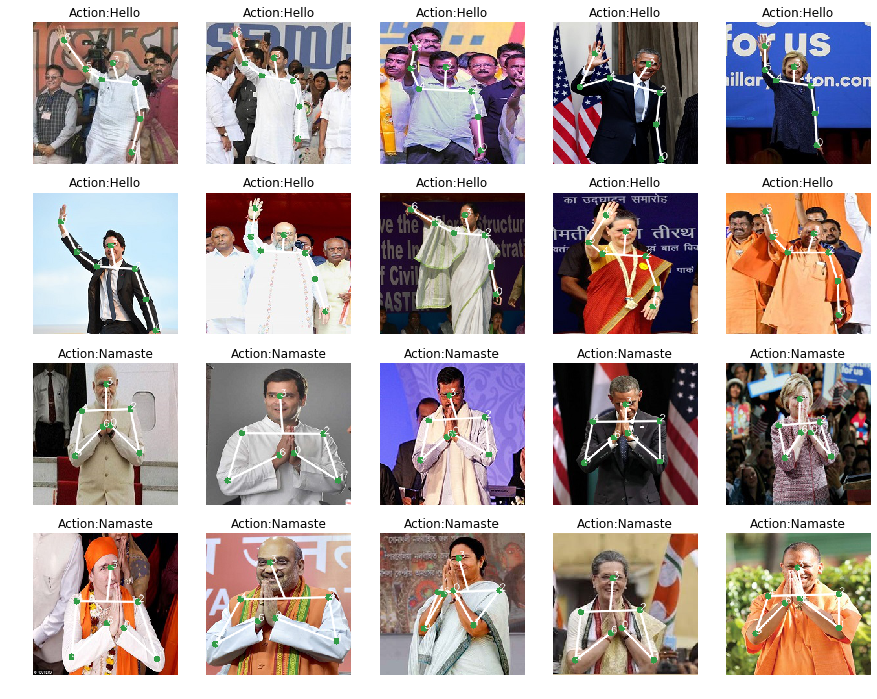

In [ ]:
plt.figure(figsize=(15,12))
for i in range(20):
    plt.subplot(4,5,(i+1))
    img = plt.imread('Action_Dataset/'+dataset['url'][i]) # Read the images
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB) # Convert the image to RGB Color space
    joints = dataset.loc[i, "j1x":"j7y"].as_matrix()
    joints = joints.astype(np.uint8).tolist()
    joints = list(zip(joints[0::2], joints[1::2]))
    plotted_image=plot_joints(img.astype(np.uint8), joints, groundtruth=True) # Plot joints
    plt.imshow(plotted_image, aspect='auto')
    plt.axis('off')
    plt.title('Action:'+dataset['label'][i])
plt.show()

### Split the dataset into training and testing sets

In [ ]:
X = pd.get_dummies(dataset.loc[:19, "j1x":"j7y"]).values # 7 body joints i.e. 14 xy coordinates
Y = pd.get_dummies(dataset.loc[:19, "label"]).values # Target classes

# Split dataset into training and testing sets, test_size is split ratio of testing size
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.30, random_state = 42)
print('Training feature shape:',x_train.shape,'Training target shape:',y_train.shape)
print('Testing feature shape:',x_test.shape,'Testing target shape:',y_test.shape)

Training feature shape: (14, 14) Training target shape: (14, 2)
Testing feature shape: (6, 14) Testing target shape: (6, 2)


### Building the Action Recognition model

In [ ]:
action_model = Sequential()
action_model.add(Dense(256, activation='relu',input_shape=(14,)))
action_model.add(Dense(128, activation='relu'))
action_model.add(Dense(64, activation='relu'))
action_model.add(Dense(32, activation='relu'))
action_model.add(Dense(16, activation='relu'))
action_model.add(Dense(8, activation='relu'))
action_model.add(Dense(2, activation='softmax'))
action_model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
action_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               3840      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 18        
Total para

### Training the model

In [ ]:
history = action_model.fit(x_train, y_train, epochs = 10, batch_size=2, verbose = 1)

Epoch 1/10
14/14 [==============================] - 1s 49ms/step - loss: 1.6432 - acc: 0.6429
Epoch 2/10
14/14 [==============================] - 0s 2ms/step - loss: 0.3525 - acc: 0.9286
Epoch 3/10
14/14 [==============================] - 0s 2ms/step - loss: 0.1497 - acc: 0.9286
Epoch 4/10
14/14 [==============================] - 0s 2ms/step - loss: 0.0318 - acc: 1.0000
Epoch 5/10
14/14 [==============================] - 0s 2ms/step - loss: 0.0126 - acc: 1.0000
Epoch 6/10
14/14 [==============================] - 0s 2ms/step - loss: 0.0092 - acc: 1.0000
Epoch 7/10
14/14 [==============================] - 0s 2ms/step - loss: 0.0061 - acc: 1.0000
Epoch 8/10
14/14 [==============================] - 0s 2ms/step - loss: 0.0032 - acc: 1.0000
Epoch 9/10
14/14 [==============================] - 0s 3ms/step - loss: 0.0017 - acc: 1.0000
Epoch 10/10
14/14 [==============================] - 0s 3ms/step - loss: 7.8100e-04 - acc: 1.0000


### Testing the model

In [ ]:
loss,acc = action_model.evaluate(x_test, y_test, verbose = 2, batch_size = 4)
print("Test Loss: %.2f" % (loss))
print("Test Accuracy: %.2f" % (acc))

Test Loss: 0.00
Test Accuracy: 1.00


### Prediction with new samples

Prediction: [4.0159075e-04 9.9959844e-01]
Actual Action:  Namaste
Predicted Action:  Namaste


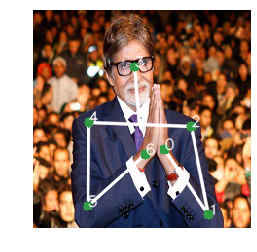

In [ ]:
id=21 # Sample which are not part of training/testing
image = plt.imread('Action_Dataset/'+dataset['url'][id])
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
prediction = np.array(dataset.loc[id, "j1x":"j7y"])
prediction = prediction.astype(np.uint8).tolist()
prediction = list(zip(prediction[0::2], prediction[1::2]))
plotted_image=plot_joints(image.astype(np.uint8), prediction, groundtruth=True)
plt.axis('off')
plt.imshow(plotted_image)

label = ['Hello','Namaste']
# Inference with the model
prediction = action_model.predict(np.expand_dims(dataset.loc[id, "j1x":"j7y"], axis=0))
print('Prediction:',prediction[0])
print('Actual Action: ',dataset.loc[id, "label"])
print('Predicted Action: ',label[prediction.argmax()]) # Label of index with maximum prediction

Prediction: [0.00103045 0.99896955]
Actual Action:  Hello
Predicted Action:  Namaste


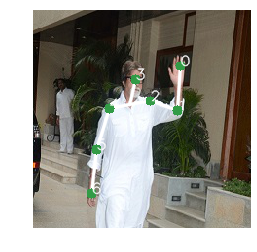

In [ ]:
id=20
image = plt.imread('Action_Dataset/'+dataset['url'][id])
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
prediction = np.array(dataset.loc[id, "j1x":"j7y"])
prediction = prediction.astype(np.uint8).tolist()
prediction = list(zip(prediction[0::2], prediction[1::2]))
plotted_image=plot_joints(image.astype(np.uint8), prediction, groundtruth=True)
plt.axis('off')
plt.imshow(plotted_image)

label = ['Hello','Namaste']
# Inference with the model
prediction = action_model.predict(np.expand_dims(dataset.loc[id, "j1x":"j7y"], axis=0))
print('Prediction:',prediction[0])
print('Actual Action: ',dataset.loc[id, "label"])
print('Predicted Action: ',label[prediction.argmax()])# Label of index with maximum prediction

### Error Analysis
Lets look at the training images for the Hello class. All the training images has pose of right hands waving. But our new sample contains pose with left hand waving. __Solution__: Do __Data Augmentation__ by flipping the pose joints in horizontal direction.   

### Data Augmentation
Lets duplicate the 20 samples for horizontal flipping

In [ ]:
dataset = pd.read_csv('Action_Dataset/action_joints.csv')
dataset = pd.concat([dataset[:20],dataset], ignore_index=True) # Duplicate the dataset
print(dataset)

                 url  j1x  j1y  j2x  j2y  j3x  ...  j5y  j6x  j6y  j7x  j7y    label
0         hello1.jpg  152  205  165  152  157  ...   90   81   74   48   28    Hello
1         hello2.jpg  142  184  144  133  134  ...   84   60   65   45   19    Hello
2         hello3.jpg  155  202  151  149  141  ...  105   47   73   53   40    Hello
3         hello4.jpg  167  216  159  161  165  ...   88   41  102   65   49    Hello
4         hello5.jpg  140  194  137  144  131  ...   92   60   75   60   37    Hello
5         hello6.jpg  189  218  174  169  157  ...  117   67   94   43   46    Hello
6         hello7.jpg  184  188  168  137  153  ...   92   69   70   76   25    Hello
7         hello8.jpg  179  161  171  118  162  ...   64   85   49   48   27    Hello
8         hello9.jpg  154  180  160  152  143  ...   97   55   79   82   36    Hello
9        hello10.jpg  174  193  172  140  158  ...   95   72   70   61   30    Hello
10      namaste1.jpg  119   98  164  142  150  ...   75   65  146

### Joint Augmentation

In [ ]:
data = np.array(dataset.loc[:, "j1x":"j7y"])
# Augment first 20 elements by flipping the joints coordinates horizontally
for i in range(0,20):
    for j in range(0,14,2):
        data[i,j] = 224-data[i,j] # Flip the the x coordinates
        data[i,:] = data[i,:].reshape(7,2)[::-1].flatten() # Flip the order of the joints

X = data[:40,:]
Y = pd.get_dummies(dataset.loc[:39, "label"]).values

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.30, random_state = 42)
print('Training feature shape:',x_train.shape,'Target Shape:',y_train.shape)
print('Training feature shape:',x_test.shape,'Target Shape:',y_test.shape)

Training feature shape: (28, 14) Target Shape: (28, 2)
Training feature shape: (12, 14) Target Shape: (12, 2)


### Model Building, Training and Testing

In [ ]:
action_model = Sequential()
action_model.add(Dense(256, activation='relu',input_shape=(14,)))
action_model.add(Dense(128, activation='relu'))
action_model.add(Dense(64, activation='relu'))
action_model.add(Dense(32, activation='relu'))
action_model.add(Dense(16, activation='relu'))
action_model.add(Dense(8, activation='relu'))
action_model.add(Dense(2, activation='softmax'))
action_model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

action_model.fit(x_train, y_train, epochs = 10, batch_size=2, verbose = 1)

loss,acc = action_model.evaluate(x_test, y_test, verbose = 2, batch_size = 4)
print("Test Loss: %.2f" % (loss))
print("Test Accuracy: %.2f" % (acc))

Epoch 1/10
28/28 [==============================] - 1s 30ms/step - loss: 1.3731 - acc: 0.5714
Epoch 2/10
28/28 [==============================] - 0s 2ms/step - loss: 0.1099 - acc: 0.9286
Epoch 3/10
28/28 [==============================] - 0s 2ms/step - loss: 0.0032 - acc: 1.0000
Epoch 4/10
28/28 [==============================] - 0s 2ms/step - loss: 0.0015 - acc: 1.0000
Epoch 5/10
28/28 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 1.0000
Epoch 6/10
28/28 [==============================] - 0s 2ms/step - loss: 6.4027e-04 - acc: 1.0000
Epoch 7/10
28/28 [==============================] - 0s 2ms/step - loss: 3.8429e-04 - acc: 1.0000
Epoch 8/10
28/28 [==============================] - 0s 2ms/step - loss: 2.7825e-04 - acc: 1.0000
Epoch 9/10
28/28 [==============================] - 0s 2ms/step - loss: 2.4957e-04 - acc: 1.0000
Epoch 10/10
28/28 [==============================] - 0s 2ms/step - loss: 1.7494e-04 - acc: 1.0000
Test Loss: 0.00
Test Accuracy: 1.00


### Prediction

Prediction: [9.9972254e-01 2.7743043e-04]
Actual Label: Hello
Predicted Label: Hello


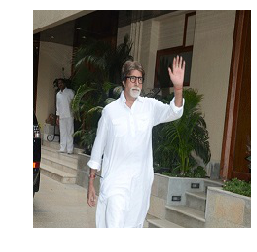

In [ ]:
id=40
img = plt.imread('Action_Dataset/'+dataset['url'][id])
plt.axis('off')
plt.imshow(img)

label = ['Hello','Namaste']
# Inference with the model
prediction = action_model.predict(np.expand_dims(dataset.loc[id, "j1x":"j7y"], axis=0))
print('Prediction:',prediction[0])
print('Actual Label:',dataset.loc[id, "label"])
print('Predicted Label:',label[prediction.argmax()])

### Translation Challenge in Action Recognition
Sometimes pose detection can return any coordinate sets within the image as human can be present anywhere in image. __Solution__: Since actual joint coordinates will not be useful in action recognition, we can treat the joints as a nodes and distance between them as weights of edges i.e. formulating it as graph model. Distance between all the joints can be represented using a symmetric distance matrix.

Prediction: [1.0000e+00 3.0502e-16]
Actual Label: Hello
Predicted Label: Hello


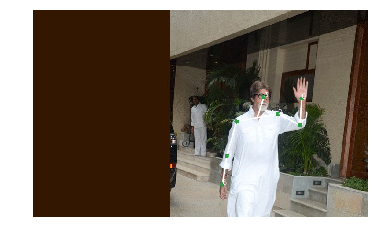

In [ ]:
img = plt.imread('Action_Dataset//hello_trans.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

joints = [610, 200, 606, 260, 556, 235, 524, 197, 462, 252, 440, 330, 430, 395]
joints = list(zip(joints[0::2], joints[1::2]))
plotted_image=plot_joints(img.astype(np.uint8), joints, groundtruth=True)
plt.axis('off')
plt.imshow(plotted_image)
joints = np.array(joints).flatten()

label = ['Hello','Namaste']
prediction = action_model.predict(np.expand_dims(joints, axis=0)) # Inference with the model
print('Prediction:',prediction[0])
print('Actual Label:',dataset.loc[id, "label"])
print('Predicted Label:',label[prediction.argmax()])

#### Lets see how to represent Action Recognition input features as graph features.
![alt text](https://i.ibb.co/4tXBRxs/pose-action.png)


### Extracting Graph-like Features from the Joints

In [ ]:
dataset = pd.read_csv('Action_Dataset/action_joints.csv')
dataset = pd.concat([dataset[:20],dataset], ignore_index=True) # Duplicate the dataset

from scipy.spatial import distance

coords = data.reshape(42,7,2) # Reshaping into joint pairs
features = [] # To store new features

for i in range(0,coords.shape[0]):
    joint_dist = distance.cdist(coords[i,:], coords[i,:], 'euclidean')
    joint_dist/=np.max(np.max(joint_dist)) # Normalize into 0 to 1
    # The above is a symmetric matrix. We only need upper or lower triangular part
    joint_dist = joint_dist[np.triu_indices(7, k = 1)] # Upper triangular matrix
    features.append(joint_dist)

features = np.array(features)

X = features[:40,:]
Y = pd.get_dummies(dataset.loc[:39, "label"]).values

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.30, random_state = 42)
print('Training feature shape:',x_train.shape,'Target Shape:',y_train.shape)
print('Training feature shape:',x_test.shape,'Target Shape:',y_test.shape)

Training feature shape: (28, 21) Target Shape: (28, 2)
Training feature shape: (12, 21) Target Shape: (12, 2)


### Model Building, Training and Testing

In [ ]:
action_model = Sequential()
action_model.add(Dense(256, activation='relu',input_shape=(21,)))
action_model.add(Dense(128, activation='relu'))
action_model.add(Dense(64, activation='relu'))
action_model.add(Dense(32, activation='relu'))
action_model.add(Dense(16, activation='relu'))
action_model.add(Dense(2, activation='softmax'))
action_model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

action_model.fit(x_train, y_train, epochs = 10, batch_size=2, verbose = 1)

loss,acc = action_model.evaluate(x_test, y_test, verbose = 2, batch_size = 4)
print("Test Loss: %.2f" % (loss))
print("Test Accuracy: %.2f" % (acc))

Epoch 1/10
28/28 [==============================] - 1s 46ms/step - loss: 0.5773 - acc: 0.7143
Epoch 2/10
28/28 [==============================] - 0s 2ms/step - loss: 0.3145 - acc: 1.0000
Epoch 3/10
28/28 [==============================] - 0s 2ms/step - loss: 0.1262 - acc: 1.0000
Epoch 4/10
28/28 [==============================] - 0s 2ms/step - loss: 0.0228 - acc: 1.0000
Epoch 5/10
28/28 [==============================] - 0s 2ms/step - loss: 0.0035 - acc: 1.0000
Epoch 6/10
28/28 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 1.0000
Epoch 7/10
28/28 [==============================] - 0s 2ms/step - loss: 6.2761e-04 - acc: 1.0000
Epoch 8/10
28/28 [==============================] - 0s 2ms/step - loss: 4.3855e-04 - acc: 1.0000
Epoch 9/10
28/28 [==============================] - 0s 2ms/step - loss: 3.4256e-04 - acc: 1.0000
Epoch 10/10
28/28 [==============================] - 0s 2ms/step - loss: 2.8095e-04 - acc: 1.0000
Test Loss: 0.00
Test Accuracy: 1.00


### Prediction

Prediction: [9.996841e-01 3.159326e-04]
Actual Label: Hello
Predicted Label: Hello


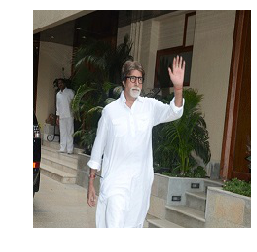

In [ ]:
id=40
img = plt.imread('Action_Dataset/'+dataset['url'][id])
plt.axis('off')
plt.imshow(img)
label = ['Hello','Namaste']
prediction = action_model.predict(np.expand_dims(features[id,:], axis=0))
print('Prediction:',prediction[0])
print('Actual Label:',dataset.loc[id, "label"])
print('Predicted Label:',label[prediction.argmax()])

### Saving the action recognition model

In [ ]:
# Structure of the model will be save in the json file
model_json = action_model.to_json()
with open("action_model.json", "w") as json_file:
    json_file.write(model_json)

# Weights and biases of the model will be save in the h5 file
action_model.save_weights("action_model.h5")
print("Saved model to disk")

Saved model to disk


### Loading the action recognition model

In [ ]:
# Load json and create model
json_file = open('action_model.json', 'r')
action_model = json_file.read()
json_file.close()
action_model = model_from_json(action_model)

# Load weights and biases
action_model.load_weights("action_model.h5")
print("Loaded model from disk")

# Compile the model in case of retraining/fine-tuning
action_model.compile(optimizer=Adam(lr=0.0001, beta_1=0.5),
                     loss='mean_squared_error')
# You can retrain/fine-tune the model or do inference with the model

Loaded model from disk


## Combining the Pose Detection Model and Action Recognition Model

Actual Label: Hello
Predicted Label: Hello


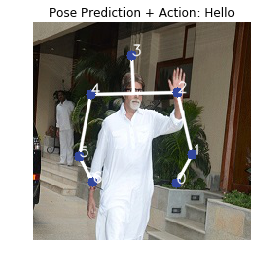

In [ ]:
# Function that takes pose, action models and image as input and predicted action as output
# This function expects the input image with human i.e. result of any human/pedestrian detection
def pose_action(pose_model,action_model,image):
    # Resizing to 224*224
    image = cv.resize(image, (224, 224))
    # Inference with pose estimation model
    pred = pose_model.predict(np.expand_dims(image, axis=0))

    #Plot the Joint Prediction
    prediction = pred[0].astype(np.uint8).tolist()
    prediction = list(zip(prediction[0::2], prediction[1::2]))
    plotted_image=plot_joints(cv.cvtColor(image, cv.COLOR_BGR2RGB).astype(np.uint8), prediction, groundtruth=False)

    coords = np.array(pred)
    coords = coords.reshape(7,2)
    joint_dist = distance.cdist(coords, coords, 'euclidean')
    joint_dist/=np.max(np.max(joint_dist)) # Normalize into 0 to 1
    joint_dist = joint_dist[np.triu_indices(7, k = 1)]

    # Inference with Action Recognition model
    label = ['Hello','Namaste']
    prediction = action_model.predict(np.expand_dims(joint_dist, axis=0))
    target,prediction = dataset.loc[id, "label"],label[prediction.argmax()]

    return plotted_image,target,prediction

id=40
image = plt.imread('Action_Dataset/'+dataset['url'][id])
# Calling the Action Recognition model
plotted_image,target,prediction = pose_action(pose_model,action_model,image)
plt.title('Pose Prediction + Action: '+prediction)
plt.axis('off')
plt.imshow(plotted_image)
print('Actual Label:',target)
print('Predicted Label:',prediction)

### Working with videos

In [ ]:
from IPython.display import HTML

# Display the video
HTML("""
<video width="224" height="224" controls>
  <source src="Action_Dataset/Waving.mp4" type="video/mp4">
</video>
""")

### Reading frames and processing

In [ ]:
video = cv.VideoCapture("Action_Dataset/Waving.mp4") #Webcam Capture
num_frames = int(video.get(cv.CAP_PROP_FRAME_COUNT)) # Number of frames, to condition the loop
j = 1
while(True):
    ret, frame = video.read() # Read frame by frame
    image,target,prediction = pose_action(pose_model,action_model,image) # Pose+Action model
    print('Frame No:',j,'\tDetected Action:',prediction) # Predicted Action
    j=j+1
    if j==num_frames: # Run until the last frame
        break
video.release()
cv.destroyAllWindows()

Frame No: 1 	Detected Action: Hello
Frame No: 2 	Detected Action: Hello
Frame No: 3 	Detected Action: Hello
Frame No: 4 	Detected Action: Hello
Frame No: 5 	Detected Action: Hello
Frame No: 6 	Detected Action: Hello
Frame No: 7 	Detected Action: Hello
Frame No: 8 	Detected Action: Hello
Frame No: 9 	Detected Action: Hello
Frame No: 10 	Detected Action: Hello
Frame No: 11 	Detected Action: Hello
Frame No: 12 	Detected Action: Hello
Frame No: 13 	Detected Action: Hello
Frame No: 14 	Detected Action: Hello
Frame No: 15 	Detected Action: Hello
Frame No: 16 	Detected Action: Hello
Frame No: 17 	Detected Action: Hello
Frame No: 18 	Detected Action: Hello
Frame No: 19 	Detected Action: Hello
Frame No: 20 	Detected Action: Hello
Frame No: 21 	Detected Action: Hello
Frame No: 22 	Detected Action: Hello
Frame No: 23 	Detected Action: Hello
Frame No: 24 	Detected Action: Hello
Frame No: 25 	Detected Action: Hello
Frame No: 26 	Detected Action: Hello
Frame No: 27 	Detected Action: Hello
Frame No: 